In [1]:
!pip install scikit-learn numpy matplotlib

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import sklearn
print(sklearn.__version__)

1.5.0


In [4]:
figdir = "./"
def savefig(fname):
    plt.savefig(os.path.join(figdir, fname))

$$
\mathcal{N}(\mathbf{y}\vert\mathbf{\mu},\mathbf{\Sigma})=\frac{1}{(2\pi)^{D/2}\vert\mathbf{\Sigma}\vert^{1/2}}\exp{\left\{-\frac{1}{2}(\mathbf{y}-\mathbf{\mu})^\intercal(\mathbf{\Sigma})^{-1}(\mathbf{y}-\mathbf{\mu})\right\}}
$$

In [5]:
def mvn2d(x, y, u, sigma):
    xx, yy = np.meshgrid(x, y)
    xy = np.c_[xx.ravel(), yy.ravel()]
    sigma_inv = np.linalg.inv(sigma)
    z = np.dot((xy - u), sigma_inv)
    z = np.sum(z * (xy - u), axis=1) # to avoid memory overflow
    z = np.exp(-0.5 * z)
    z = z / (2 * np.pi * np.linalg.det(sigma) ** 0.5)
    return z.reshape(xx.shape)


## Make data

AB are the last two digits of your student number.
For example, if your student number is 170201003 then AB is 03 (A = 0, B = 3).

If any digit is 0, please add +1. In the example above, A will become 1.

Please fill A and in the code below as follows.

Sigma2 = np.array([[A, 0], [0, B]])

In [6]:
mu1 = [0,0]
Sigma1 = np.array([[4, 1], [1, 2]])

mu2 = [0, 4]
Sigma2 = np.array([[2, 0], [0, 2]])

mu3 = [4, 4]
Sigma3 = np.array([[3, -3], [-3, 4]])

mus = [mu1, mu2, mu3]
sigmas = [Sigma1, Sigma2, Sigma3]

In [7]:
ngrid = 200
np.random.seed(0)

def make_data(mu, sigma, n_samples_per_class = 30, seed = 0):
    np.random.seed(seed)
    x = []
    labels = []
    nclasses = len(mu)
    for i in range(nclasses):
        x.append(np.random.multivariate_normal(mu[i], sigma[i], n_samples_per_class))
        labels.append([i] * n_samples_per_class)
    return x, labels

def make_grid(x):
    #points = np.vstack(x)
    #x_min, y_min = np.min(points, axis=0)
    #x_max, y_max = np.max(points, axis=0)
    #x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    #y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    x_range = np.linspace(-5, 10, ngrid)
    y_range = np.linspace(-5, 10, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy, x_range, y_range

def plot_dboundaries(xx, yy, z, z_p):
    plt.pcolormesh(xx, yy, z, alpha=0.1)
    plt.jet()
    nclasses = z_p.shape[1]
    for j in range(nclasses):
        plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], colors="k")

def plot_points(x):
    c = "bgr"
    m = "xos"
    for i, point in enumerate(x):
        N = point.shape[0]
        #nplot = min(N, 30)
        nplot = N
        plt.plot(point[:nplot, 0], point[:nplot, 1], c[i] + m[i])

def plot_contours(xx, yy, x_range, y_range, u, sigma):
    nclasses = len(u)
    c = "bgr"
    m = "xos"
    for i in range(nclasses):
        prob = mvn2d(x_range, y_range, u[i], sigma[i])
        cs = plt.contour(xx, yy, prob, colors=c[i])

def make_one_hot(yhat):
    yy = yhat.reshape(-1, 1)
    # enc = OneHotEncoder(sparse=False)
    enc = OneHotEncoder(sparse_output=False)
    Y = enc.fit_transform(yy)
    return Y

### Making training data

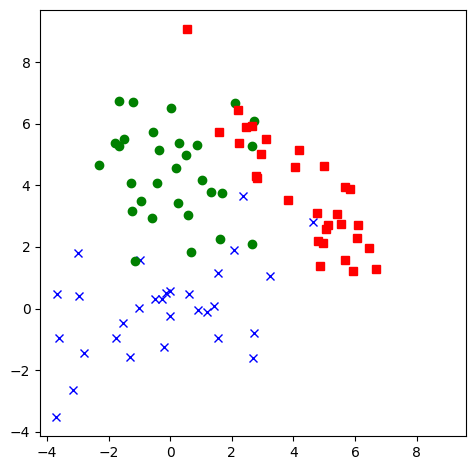

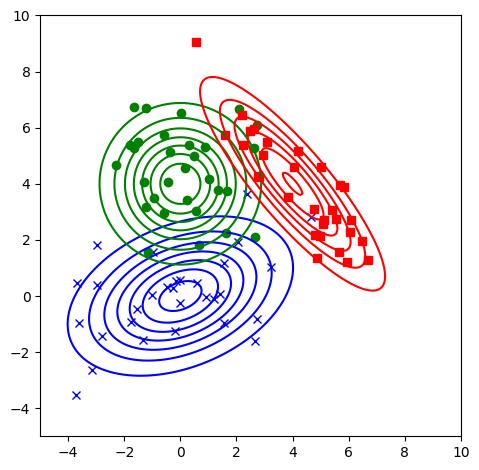

In [8]:
x, labels = make_data(mus, sigmas, n_samples_per_class = 30, seed = 0)
xx, yy, x_range, y_range = make_grid(x)
X = np.vstack(x)
Y = np.hstack(labels)

plt.figure()
plot_points(x)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_data.pdf")
plt.show()

plt.figure()
plot_points(x)
plot_contours(xx, yy, x_range, y_range, mus, sigmas)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_contours.pdf")
plt.show()

### Making test data

**Set the random seed for creating test data as AB.**

In [9]:
x_test, labels_test = make_data(mus, sigmas, n_samples_per_class=100, seed=13)
X_test = np.vstack(x_test)
Y_test = np.hstack(labels_test)

## Code for model fitting and plotting

In [10]:
def fit_and_plot(clf, name, mus, sigmas):
    clf.fit(X, Y)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(Y_test, y_pred)
    print("Test accuracy: ", acc)

    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(ngrid, ngrid)
    z_p = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    yhat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Yhat = make_one_hot(yhat)


    plt.figure()
    plot_dboundaries(xx, yy, z, Yhat)
    plot_points(x_test)
    plot_contours(xx, yy, x_range, y_range, mus, sigmas)
    plt.title(name)
    plt.axis("square")
    plt.tight_layout()
    savefig("gda_2d_{}.pdf".format(name))
    plt.show()

## Linear Discriminant Analysis (LDA)

In [11]:
def estimate_mvn_tied(X, Y):
    classes = np.unique(Y)
    nclasses = len(classes)
    Sigma = np.cov(X, rowvar=False) # rowvar=False: each column represents a variable, while the rows contain observations.
    sigmas = [Sigma] * nclasses
    mus = []
    for c in classes:
        ndx = Y == c
        Xc = X[ndx]
        mu_c = np.mean(Xc, axis=0)
        mus.append(mu_c)
    return mus, sigmas

mus_tied, sigmas_tied = estimate_mvn_tied(X, Y)

Test accuracy:  0.8766666666666667


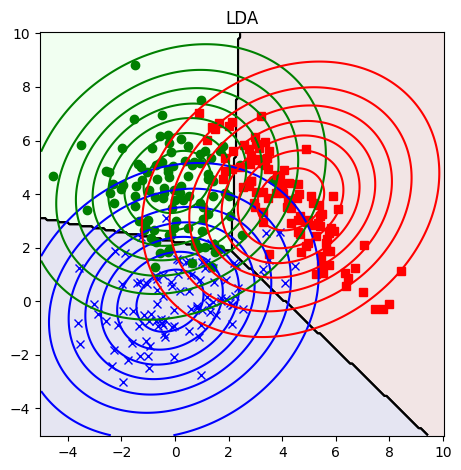

In [12]:
fit_and_plot(LDA(), "LDA", mus_tied, sigmas_tied)

## Gaussian Naive Bayes Classifier

In [13]:
def estimate_mvns_diag(X, Y):
    classes = np.unique(Y)
    mus = []
    sigmas = []
    for c in classes:
        # Estimate the mean vector of each class
        mu_c = np.mean(X[Y == c], axis=0)
        mus.append(mu_c)

        # Estimate the diagonal covariance matrix of each class
        sigma_c = np.var(X[Y == c], axis=0)
        Sigma_c = np.diag(sigma_c)
        sigmas.append(Sigma_c)
        
    return mus, sigmas

mus_est_diag, sigmas_est_diag = estimate_mvns_diag(X, Y)

Test accuracy:  0.8833333333333333


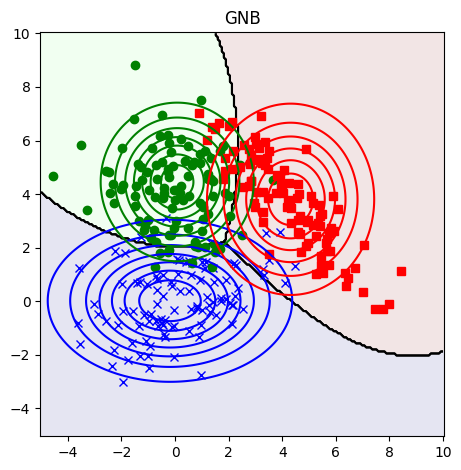

In [14]:
fit_and_plot(GaussianNB(), "GNB", mus_est_diag, sigmas_est_diag)

## Quadratic Discriminant Analysis (QDA)

In [15]:
def estimate_mvns(X, Y):
    classes = np.unique(Y)
    mus = []
    sigmas = []
    for c in classes:
        # Estimate the mean vector of each class
        mu_c = np.mean(X[Y == c], axis=0)
        mus.append(mu_c)

        # Estimate the full covariance matrix of each class
        Sigma_c = np.cov(X[Y == c], rowvar=False)
        sigmas.append(Sigma_c)
        
    return mus, sigmas

mus_est, sigmas_est = estimate_mvns(X, Y)

Test accuracy:  0.91


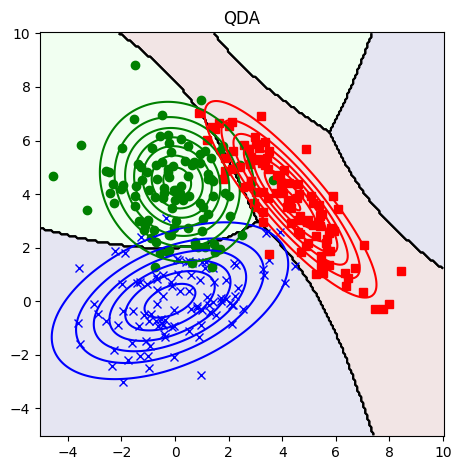

In [16]:
fit_and_plot(QDA(), "QDA", mus_est, sigmas_est)

## Compare Gaussian Naive Bayes, LDA, and QDA.

Write your comments here!

- LDA: Linear decision boundary; đơn giản hơn và ít tính toán hơn. Ma trận chuẩn hóa và hiệp phương sai bằng nhau.
- GNB: Đơn giản hơn với strong independence assumption; thời gian thực thi nhanh. Tính độc lập có điều kiện và tính chuẩn tắc.
- QDA: Quadratic decision boundary; Phức tạp và tính toán nhiều hơn. Ma trận bình thường nhưng hiệp phương sai khác nhau cho mỗi lớp.
